In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_utils import load_data, split_dataset
from processing import extract_by_vars, extract_by_means

np.random.seed(17000)
sns.set_style("whitegrid")

In [2]:
data = load_data(mode="coad", log=True)

In [3]:
df = data["coad"]

In [4]:
data_splits = split_dataset(df)

In [5]:
target = "COVAR_N_status"

In [6]:
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import ensemble

In [17]:
def run(model_type, data_splits, features, target):
    X_train, X_test, y_train, y_test = data_splits
    if features == "all":
        features = X_train.columns
    model = model_type
    model.fit(X_train[features], y_train[target])
    preds = model.predict(X_test[features])
    results = {}
    results["accuracy"] = metrics.accuracy_score(y_test[target], preds)
    return model, results

In [18]:
# All features
results = run(
    linear_model.LogisticRegression(max_iter=1000),
    data_splits,
    "all",
    target
)
results[1]["accuracy"]

0.7070063694267515

In [19]:
# All features on Random Forest
results = run(
    ensemble.RandomForestClassifier(),
    data_splits,
    "all",
    target
)
results[1]["accuracy"]

0.6878980891719745

In [20]:
model = linear_model.LogisticRegression(max_iter=1000)
model.fit(X_train, y_train[target])
preds = model.predict(X_test)
print(metrics.classification_report(y_test[target], preds))
initial_accuracy = metrics.accuracy_score(y_test[target], preds)

NameError: name 'X_train' is not defined

In [8]:
coef_all = pd.DataFrame(model.coef_, columns=model.feature_names_in_).loc[0]
abs(coef_all).sort_values(ascending=False)[:20]

GNGT1       0.048389
SLC5A8      0.048084
TBC1D3C     0.047320
IL17C       0.043503
S100A7      0.042278
PGAM2       0.041718
CERS3       0.041111
PPIAL4A     0.040480
NPIPA2      0.039981
RLBP1       0.039468
C5orf46     0.038920
FEZF1       0.038606
LRRC14B     0.037820
GNAT2       0.037732
C12orf71    0.037593
SLC28A1     0.037448
CYP2A6      0.036563
C11orf87    0.036408
URAD        0.035810
HUS1B       0.035775
Name: 0, dtype: float64

In [9]:
k = 300
features = extract_by_vars(X_train, y_train, target, 1, k)

In [10]:
model = linear_model.LogisticRegression(max_iter=500)
model.fit(X_train[features], y_train[target])
preds = model.predict(X_test[features])
accuracy = metrics.accuracy_score(y_test[target], preds)

In [11]:
coef_1000 = pd.DataFrame(model.coef_, columns=model.feature_names_in_).loc[0]
abs(coef_1000).sort_values(ascending=False)[:20]

HAPLN2      0.212094
CPB1        0.209731
SLC5A8      0.206071
IL17C       0.202198
C5orf46     0.197530
GNGT1       0.192847
TAS2R20     0.188123
F8A3        0.187093
HUS1B       0.180883
CLCNKB      0.175973
OR2W3       0.168699
EGF         0.168063
S100A7      0.163320
C17orf98    0.161904
GAGE1       0.152777
HESX1       0.150130
PGLYRP4     0.148092
KLHL34      0.147945
ZNF280A     0.147768
CELA3B      0.145288
Name: 0, dtype: float64

In [12]:
abs(coef_1000).sort_values(ascending=False).index

Index(['HAPLN2', 'CPB1', 'SLC5A8', 'IL17C', 'C5orf46', 'GNGT1', 'TAS2R20',
       'F8A3', 'HUS1B', 'CLCNKB',
       ...
       'RBP2', 'FSTL4', 'C1QTNF9', 'PROK2', 'CKM', 'LRRC26', 'B3GNT6', 'TTC6',
       'CELF3', 'KLK8'],
      dtype='object', length=300)

In [13]:
abs(coef_all).sort_values(ascending=False)[:1000].index

Index(['GNGT1', 'SLC5A8', 'TBC1D3C', 'IL17C', 'S100A7', 'PGAM2', 'CERS3',
       'PPIAL4A', 'NPIPA2', 'RLBP1',
       ...
       'TCHH', 'ZNF705E', 'TMSB15A', 'CELF3', 'RNF183', 'CCL7', 'CD163L1',
       'MYOZ3', 'GZMB', 'ARC'],
      dtype='object', length=1000)

In [14]:
common_features = set(abs(coef_1000).sort_values(ascending=False).index) & \
set(abs(coef_all).sort_values(ascending=False)[:1000].index)

In [15]:
len(common_features)

192

In [16]:
k_values = range(200, 1500, 25)
var_accuracies = []
for k in k_values:
    features = extract_by_vars(X_train, y_train, target, 1, k)
    model = linear_model.LogisticRegression(max_iter=1000)
    model.fit(X_train[features], y_train[target])
    preds = model.predict(X_test[features])
    accuracy = metrics.accuracy_score(y_test[target], preds)
    var_accuracies.append(accuracy)

In [17]:
mean_accuracies = []
for k in k_values:
    features = extract_by_means(X_train, y_train, target, 1, k)
    model = linear_model.LogisticRegression(max_iter=1000)
    model.fit(X_train[features], y_train[target])
    preds = model.predict(X_test[features])
    accuracy = metrics.accuracy_score(y_test[target], preds)
    mean_accuracies.append(accuracy)

In [18]:
og_accuracies = []
for k in k_values:
    features = abs(coef_all).sort_values(ascending=False)[:k].index.to_numpy()
    model = linear_model.LogisticRegression(max_iter=1000)
    model.fit(X_train[features], y_train[target])
    preds = model.predict(X_test[features])
    accuracy = metrics.accuracy_score(y_test[target], preds)
    og_accuracies.append(accuracy)

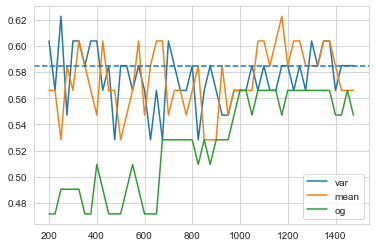

In [19]:
plt.plot(k_values, var_accuracies, label="var")
plt.plot(k_values, mean_accuracies, label="mean")
plt.plot(k_values, og_accuracies, label="og")
plt.axhline(initial_accuracy, linestyle='--')
plt.legend()